# ***`Module 2 Homework`***
---

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the Colab covered at the livestream to re-use the code snippets.

---
## ***`Initial Public Offering`***

- "IPO" in stock markets stands for Initial Public Offering. It refers to the process where a private company offers shares to the public for the first time. This move to go public is often undertaken by companies seeking to raise capital to expand, reduce debt, or for other financial reasons. After an IPO, the company's shares are listed on a stock exchange, where they can be bought and sold by investors.
#
- IPO filings are the formal documents that a company submits to securities regulators before it can proceed with an Initial Public Offering (IPO). These filings are essential because they provide detailed information about the company's business, financial status, and management.

In [1]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

## ***`Question 1: IPO Filings Web Scraping and Data Processing`***
---

What's the total sum ($m) of 2023 filings that happened on Fridays?

Re-use the [Code Snippet 1] example to get the data from web for this endpoint: https://stockanalysis.com/ipos/filings/ Convert the 'Filing Date' to datetime(), 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs). Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given). You may be inspired by the function extract_numbers() in [Code Snippet 4], or you can write your own function to "parse" a string. Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)

Find the total sum in $m (millions of USD, closest INTEGER number) for all filings during 2023, which happened on Fridays (Date.dt.dayofweek()==4). You should see 32 records in total, 25 of it is not null.

(additional: you can read about S-1 IPO filing to understand the context: https://www.dfinsolutions.com/knowledge-hub/thought-leadership/knowledge-resources/what-s-1-ipo-filing)

- Read data:

In [17]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/filings/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(response.text)
print(f"Type: {type(ipo_dfs)}; N elements: {len(ipo_dfs)}")
ipo_dfs

Type: <class 'list'>; N elements: 2


/var/folders/w6/jtmt_0cj77x4nfxlghckk_zc0000gn/T/ipykernel_4025/2618181750.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipo_dfs = pd.read_html(response.text)


[      Filing Date Symbol                           Company Name  \
 0     May 3, 2024    TBN         Tamboran Resources Corporation   
 1    Apr 29, 2024   HWEC                   HW Electro Co., Ltd.   
 2    Apr 29, 2024   DTSQ  DT Cloud Star Acquisition Corporation   
 3    Apr 26, 2024   EURK                Eureka Acquisition Corp   
 4    Apr 26, 2024    HDL    Super Hi International Holding Ltd.   
 ..            ...    ...                                    ...   
 320  Jan 21, 2020   GOXS                            Goxus, Inc.   
 321  Jan 21, 2020   UTXO                 UTXO Acquisition, Inc.   
 322   Dec 9, 2019   LOHA                           Loha Co. Ltd   
 323   Oct 4, 2019   ZGHB  China Eco-Materials Group Co. Limited   
 324  Dec 27, 2018   FBOX              Fit Boxx Holdings Limited   
 
         Price Range Shares Offered  
 0                 -              -  
 1             $3.00        3750000  
 2            $10.00        6000000  
 3            $10.00        50

- Inspect all tables:

In [18]:
ipo_dfs[0].head()

,Filing Date,Symbol,Company Name,Price Range,Shares Offered
0,"May 3, 2024",TBN,Tamboran Resources Corporation,-,-
1,"Apr 29, 2024",HWEC,"HW Electro Co., Ltd.",$3.00,3750000
2,"Apr 29, 2024",DTSQ,DT Cloud Star Acquisition Corporation,$10.00,6000000
3,"Apr 26, 2024",EURK,Eureka Acquisition Corp,$10.00,5000000
4,"Apr 26, 2024",HDL,Super Hi International Holding Ltd.,-,-


In [19]:
ipo_dfs[1].head()

,Date,Symbol,Name
0,May 8,NNE,Nano Nuclear Energy
1,May 9,SVCO,Silvaco Group
2,May 9,PAL,Proficient Auto Logistics
3,May 10,ZK,ZEEKR Intelligent Technology Holding
4,May 10,LRTX,Lirum Therapeutics


In [23]:
filings_df = ipo_dfs[0]
filings_df.dtypes.to_frame(name="Data Type")

,Data Type
Filing Date,object
Symbol,object
Company Name,object
Price Range,object
Shares Offered,object


- Data Cleaning & Feature Extraction:

In [33]:
# 0) extract data for year 2023
filings_23 = filings_df[filings_df['Filing Date'].str.contains('2023')].copy()

# 1) convert filing date to datetime
filings_23['Filing Date'] = pd.to_datetime(filings_23['Filing Date'])

# 2) 'Shares Offered' to float64 (if '-' is encountered, populate with NaNs)
filings_23['Shares Offered'] = filings_23['Shares Offered'].apply(lambda x: np.nan if x == '-' else float(x))

# 3) Define a new field 'Avg_price' based on the "Price Range", which equals to NaN if no price is specified, to the price (if only one number is provided), or to the average of 2 prices (if a range is given). You may be inspired by the function extract_numbers() in [Code Snippet 4], or you can write your own function to "parse" a string.
def extract_numbers(price_range:str) -> float:
    # Extracts numbers from the price range string and calculates the average price
    if pd.isna(price_range):
        return np.nan
    numbers = [float(x) for x in price_range.replace('$', '').split() if x.replace('.', '', 1).isdigit()]
    if len(numbers) == 1:
        return numbers[0]
    elif len(numbers) == 2:
        return sum(numbers) / 2
    return np.nan

filings_23['Avg_price'] = filings_23['Price Range'].apply(extract_numbers)


# Define a column "Shares_offered_value", which equals to "Shares Offered" * "Avg_price" (when both columns are defined; otherwise, it's NaN)
filings_23['Shares_offered_value'] = filings_23['Shares Offered'] * filings_23['Avg_price']

# Filter for filings that happened on Fridays in 2023
mask = (filings_23['Filing Date'].dt.year == 2023) & (filings_23['Filing Date'].dt.dayofweek == 4) # You should see 32 records in total, 25 of it is not null.
friday_filings = filings_23[ mask ].copy()


print(friday_filings.shape)
friday_filings.head(9)

(32, 7)


,Filing Date,Symbol,Company Name,Price Range,Shares Offered,Avg_price,Shares_offered_value
50,2023-12-29,LEC,Lafayette Energy Corp,$3.50 - $4.50,1200000.0,4.0,4800000.0
51,2023-12-29,EPSM,Epsium Enterprise Limited,-,NaN,NaN,NaN
54,2023-12-22,CHLW,Chun Hui Le Wan International Holding Group Ltd,-,NaN,NaN,NaN
55,2023-12-22,LZMH,LZ Technology Holdings Limited,-,NaN,NaN,NaN
60,2023-12-15,GIT,Going International Holding Company Limited,-,NaN,NaN,NaN
62,2023-12-08,ENGS,Energys Group Limited,$4.00 - $6.00,2000000.0,5.0,10000000.0
63,2023-12-08,LNKS,Linkers Industries Limited,$4.00 - $6.00,2200000.0,5.0,11000000.0
82,2023-10-27,RAY,Raytech Holding Limited,$4.00 - $5.00,1500000.0,4.5,6750000.0
89,2023-10-13,ORIS,Oriental Rise Holdings Limited,$4.00,2000000.0,4.0,8000000.0


In [36]:
mask = (filings_23['Filing Date'].dt.year == 2023) & (filings_23['Filing Date'].dt.dayofweek == 3) # You should see 32 records in total, 25 of it is not null.
thursday_filings = filings_23[ mask ].copy()

- Result:

In [37]:
# Calculate the total sum in millions of USD
total_sum_friday   = friday_filings['Shares_offered_value'].sum() / 1e6
total_sum_thursday = thursday_filings['Shares_offered_value'].sum() / 1e6

# Print the result
print(f"Total sum of 2023 filings on Fridays: ${total_sum_friday:.0f} million")
print(f"Total records: {len(friday_filings)}, Non-null values: {friday_filings['Shares_offered_value'].notna().sum()}")
print()
print(f"Total sum of 2023 filings on Thursdays: ${total_sum_thursday:.0f} million")
print(f"Total records: {len(thursday_filings)}, Non-null values: {thursday_filings['Shares_offered_value'].notna().sum()}")

Total sum of 2023 filings on Fridays: $286 million
Total records: 32, Non-null values: 25

Total sum of 2023 filings on Thursdays: $414 million
Total records: 23, Non-null values: 17


### ***Context:***
---
#### ***1. Understanding IPO Dynamics***
- Initial Public Offerings (IPOs) are significant events in the stock market as they represent a company's transition from private to public. Analyzing IPOs helps understand market trends, investor appetite, and how different factors affect the initial market reception of new public companies.
#
- By analyzing IPO filings, you get insights into the sectors attracting investment, the size of companies going public, and other market dynamics.

#### ***2. Temporal Analysis (Focus on Fridays)***
- Analyzing IPOs based on the day of the week they are filed provides insights into strategic decisions made by companies and underwriters. There is a belief in financial circles that the timing of an IPO can affect its initial performance and subsequent investor interest.
#
- Fridays are particularly interesting because they are at the end of the trading week, which might influence how much attention the IPO gets. Market participants might react differently to IPOs based on their timing, with some days believed to be more favorable for announcements and listings due to psychological and behavioral factors of investors.

#### ***4. Quantitative Analysis***
- Calculating the total monetary value of IPOs on specific days can help quantify the economic significance of these filings. This can lead to more detailed analysis, like comparing different days or looking for trends over time.

#### ***5. Thursday vs. Friday Comparison***
The analysis of IPO filings on Thursdays and Fridays in 2023 reveals some notable trends and differences:

- **Higher Capital on Thursdays:** Despite fewer IPOs (23 on Thursday vs. 32 on Friday), Thursdays saw more capital raised, totaling $414 million, compared to $286 million on Fridays. This suggests that the average IPO size on Thursdays is larger than on Fridays.
#
- **Implications for Strategic Timing:** The difference in capital raised may indicate that companies opting for Thursday IPOs are either larger or issue shares at higher prices, possibly to capture a more engaged investor audience ahead of the weekend.
#
- **Potential Market Preferences:** The preference for Thursday could reflect investor behaviors or market sentiments that favor absorbing and acting on new financial events earlier in the week, avoiding the weekend slowdown.
#
- **Further Analysis Opportunities:** These findings open the door to deeper analyses, such as comparing these days with other weekdays, exploring sector-specific trends, and assessing post-IPO performance metrics to understand broader market implications and investor responses.

---

- Pattern Analysis for all days:

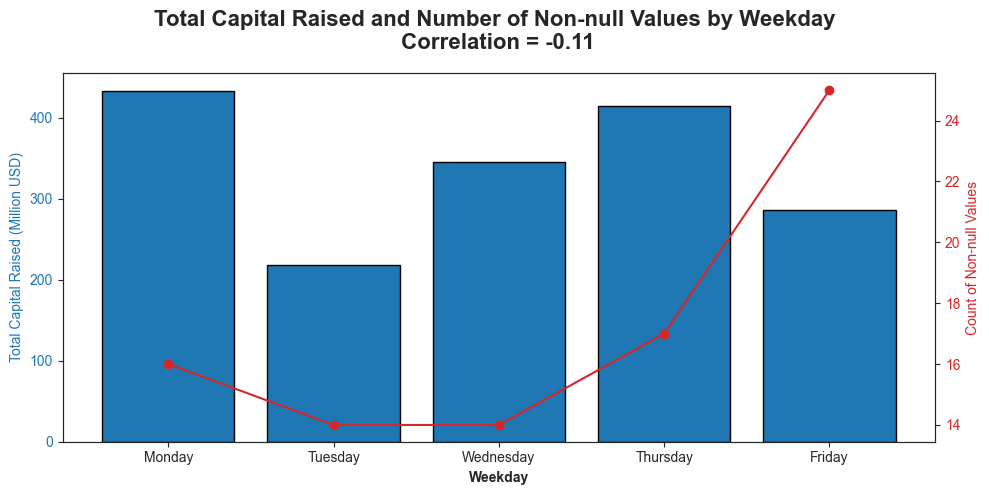

In [55]:
import pandas as pd
import seaborn as sns
sns.set_style("ticks")

# Assuming filings_23 is already loaded and 'Filing Date' is converted to datetime
# Filter for year 2023 and add weekday names
filings_23['weekday'] = filings_23['Filing Date'].dt.weekday
filings_23 = filings_23[filings_23['Filing Date'].dt.year == 2023]

# Group by weekday to calculate sums and counts
summary = filings_23.groupby(filings_23['Filing Date'].dt.day_name())['Shares_offered_value'].agg(['sum', 'count'])
summary['sum'] /= 1e6  # Convert to millions of USD

# Sorting index by day of the week to ensure correct order (Monday to Friday)
summary = summary.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))
corr = summary['sum'].corr(summary['count'])
fig.suptitle(f'Total Capital Raised and Number of Non-null Values by Weekday\n Correlation = {corr:.2f}', fontsize=16, weight='bold')

# Bar plot for total sum of shares offered in millions of USD
color = 'tab:blue'
ax1.set_xlabel('Weekday', weight='bold')
ax1.set_ylabel('Total Capital Raised (Million USD)', color=color)
ax1.bar(summary.index, summary['sum'], color=color, edgecolor='black')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for the count of non-null values
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Count of Non-null Values', color=color)
ax2.plot(summary.index, summary['count'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To ensure there's no layout overlap
plt.show()


In [173]:
summary.head()

,sum,count
Filing Date,,
Monday,433.037500,16
Tuesday,218.335438,14
Wednesday,344.800004,14
Thursday,414.247503,17
Friday,285.700000,25


<Axes: xlabel='sum', ylabel='count'>

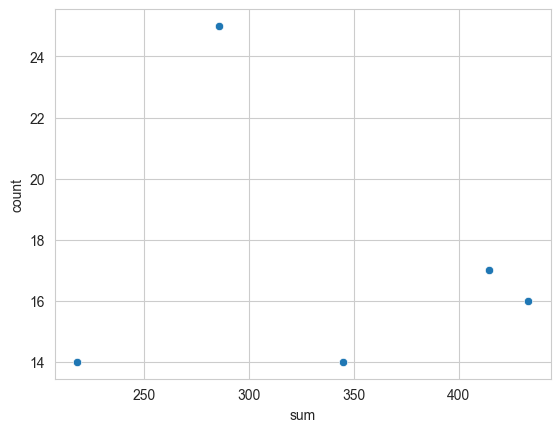

In [174]:
sns.scatterplot(data =summary, x='sum', y='count')

## ***`Question 2: IPOs "Fixed days hold" strategy`***
---

Find the optimal number of days X (between 1 and 30), where 75% quantile growth is the highest?

Reuse [Code Snippet 1] to retrieve the list of IPOs from 2023 and 2024 (from URLs: https://stockanalysis.com/ipos/2023/ and https://stockanalysis.com/ipos/2024/). Get all OHLCV daily prices for all stocks with an "IPO date" before March 1, 2024 ("< 2024-03-01") - 184 tickers (without 'RYZB'). Please remove 'RYZB', as it is no longer available on Yahoo Finance.

Sometimes you may need to adjust the symbol name (e.g., 'IBAC' on stockanalysis.com -> 'IBACU' on Yahoo Finance) to locate OHLCV prices for all stocks. Also, you can see the ticker changes using this link:https://stockanalysis.com/actions/changes/. Some of the tickers (like 'DYCQ' and 'LEGT') were on the market less than 30 days (11 and 21 days, respectively). Let's leave them in the dataset; it just means that you couldn't hold them for more days than they were listed.

Let's assume you managed to buy a new stock (listed on IPO) on the first day at the [Adj Close] price]. Your strategy is to hold for exactly X full days (where X is between 1 and 30) and sell at the "Adj. Close" price in X days (e.g., if X=1, you sell on the next day). Find X, when the 75% quantile growth (among 185 investments) is the highest.

HINTs:

- You can generate 30 additional columns: growth_future_1d ... growth_future_30d, join that with the table of min_dates (first day when each stock has data on Yahoo Finance), and perform vector operations on the resulting dataset.
#
- You can use the DataFrame.describe() function to get mean, min, max, 25-50-75% quantiles.

Additional:

- You can also ensure that the mean and 50th percentile (median) investment returns are negative for most X values, implying a wager for a "lucky" investor who might be in the top 25%.
#
- What's your recommendation: Do you suggest pursuing this strategy for an optimal X?
---

- retrieve all ipo symbols and dates:

In [139]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url_23, url_24 = "https://stockanalysis.com/ipos/2023/", "https://stockanalysis.com/ipos/2024/"

response_23, response_24 = requests.get(url_23, headers=headers), requests.get(url_24, headers=headers)

ipos_23, ipos_24 = pd.read_html(response_23.text)[0], pd.read_html(response_24.text)[0]

ipos_df = pd.concat([ipos_23, ipos_24]).reset_index(drop=True)

# select only neccessary columns
ipos_df = ipos_df[['IPO Date', 'Symbol']]

# datetime casting
ipos_df['IPO Date'] = pd.to_datetime(ipos_df['IPO Date'], format='%b %d, %Y', errors='coerce')

# filter
ipos_df = ipos_df[ipos_df['IPO Date'] < '2024-03-01']
# Remove the ticker that is not available
ipos_df = ipos_df[ipos_df['Symbol'] != 'RYZB']
# Check how many NaT values were generated
print(ipos_df['IPO Date'].isna().sum()) # great!!!

print(ipos_df.shape)
ipos_df.head()

0
(184, 2)


/var/folders/w6/jtmt_0cj77x4nfxlghckk_zc0000gn/T/ipykernel_4025/2875163406.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipos_23, ipos_24 = pd.read_html(response_23.text)[0], pd.read_html(response_24.text)[0]
/var/folders/w6/jtmt_0cj77x4nfxlghckk_zc0000gn/T/ipykernel_4025/2875163406.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  ipos_23, ipos_24 = pd.read_html(response_23.text)[0], pd.read_html(response_24.text)[0]


,IPO Date,Symbol
0,2023-12-27,IROH
1,2023-12-19,LGCB
2,2023-12-15,ZKH
3,2023-12-15,BAYA
4,2023-12-14,INHD


- map ipo names from first data source to the actual names from yahoo:

In [140]:
# firstly get actual symbol names for yahoo and map them
import requests
from bs4 import BeautifulSoup

url = "https://stockanalysis.com/actions/changes/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# Find the table, you might need to adjust this if there are multiple tables or identifiers
table = soup.find('table')  # Adjust with `id` or `class_` if necessary
rows = table.find_all('tr')

# Dictionary to hold the ticker changes
ticker_changes = {}

# Loop through rows and skip the header
for row in rows[1:]:  # assuming the first row is the header
    cols = row.find_all('td')
    if len(cols) >= 3:  # Make sure there are enough columns
        old_symbol = cols[1].text.strip()
        new_symbol = cols[2].text.strip()
        ticker_changes[old_symbol] = new_symbol

ticker_changes

{'FUV': 'FUVV',
 'XLYO': 'XYLO',
 'DCFCW': 'DCFWQ',
 'MDGS': 'XYLO',
 'GGE': 'GGEI',
 'CBD': 'CBDBY',
 'OSA': 'OSAP',
 'ARRW': 'AILE',
 'CNXA': 'YYAI',
 'STRC': 'PDYN',
 'KYCH': 'ZOOZ',
 'VIEWW': 'VIWWQ',
 'ASCA': 'NIVF',
 'CASA': 'CASSQ',
 'ONTX': 'TRAW',
 'APAC': 'FAAS',
 'WETG': 'NXTT',
 'GEV.W': 'GEV',
 'WNNR': 'ZPTA',
 'CVCY': 'CWBC',
 'TWOA': 'LPA',
 'AGE': 'SER',
 'CNDB': 'GCTS',
 'FIXX': 'QTTB',
 'DWAC': 'DJT',
 'FSR': 'FSRN',
 'FLT': 'CPAY',
 'VJET': 'VJTTY',
 'GRPH': 'LENZ',
 'ADOC': 'COOT',
 'HCMA': 'MRNO',
 'SVFD': 'NITO',
 'PUYI': 'HPH',
 'ENCP': 'GTI',
 'CYT': 'CYTT',
 'DHCA': 'BNAI',
 'XPDB': 'AIRJ',
 'ESAC': 'ZEO',
 'INPX': 'XTIA',
 'SASI': 'NTRP',
 'LBBB': 'NMHI',
 'GIA': 'QTI',
 'CPSI': 'TBRG',
 'PEAK': 'DOC',
 'BODY': 'BODI',
 'BFX': 'BFXXQ',
 'ARIZ': 'FUFU',
 'POL': 'POLCQ',
 'SZZL': 'CRML',
 'ROI': 'ROII',
 'TMST': 'MTUS',
 'AMEH': 'ASTH',
 'LCAA': 'LOT',
 'JT': 'JTCHY',
 'CHEA': 'SELX',
 'LGST': 'TVGN',
 'FLME': 'SOC',
 'PBAX': 'CERO',
 'SEAS': 'PRKS',
 'QFTA': 'A

In [141]:
# second map the Symbol column from ipo_df to ticker_changes
ipos_df['Symbol'] = ipos_df['Symbol'].map(ticker_changes).fillna(ipos_df['Symbol']) # fillna is used to keep the original symbol if no change is found
ipos_df.isnull().sum()

IPO Date    0
Symbol      0
dtype: int64

In [207]:
ipos_df.head(3)

,IPO Date,Symbol
0,2023-12-27,IROH
1,2023-12-19,LGCB
2,2023-12-15,ZKH


- ***`Identify first available trading day by hint:`***

In [220]:
import yfinance as yf
import pandas as pd

# Define the IPO date and ticker
ticker_ipo_date = pd.Timestamp('2023-12-19', tz='UTC')  # Make timezone aware using UTC
ticker = 'LGCB'

# Broaden the data fetching window
start_date = ticker_ipo_date - pd.Timedelta(days=10)  # 10 days before the IPO
end_date = ticker_ipo_date + pd.Timedelta(days=15)    # 15 days after the IPO

# Fetch preliminary data
try:
    preliminary_data = yf.download(ticker, start=start_date, end=end_date)
    first_valid_date = preliminary_data['Adj Close'].first_valid_index()
    print("First available data on:", first_valid_date)

    if first_valid_date:
        # If there's a valid trading day, fetch 30 days of data from that day
        adjusted_data = yf.download(ticker, start=first_valid_date, end=first_valid_date + pd.Timedelta(days=30))
    else:
        print("No trading data found within the adjusted range.")
except Exception as e:
    print(f"Failed to download data: {e}")
adjusted_data.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

First available data on: 2023-12-26 00:00:00


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-26,2.05,2.200,1.87,1.960,1.960,338600
2023-12-27,1.92,2.030,1.55,1.590,1.590,369000
2023-12-28,1.53,1.720,1.28,1.720,1.720,285300
2023-12-29,1.72,1.940,1.55,1.560,1.560,137400
2024-01-02,1.63,1.679,1.55,1.656,1.656,75500


- `yessir that below worked!!!`

In [227]:
import yfinance as yf
import pandas as pd

def find_first_trading_day(ticker, ipo_date):
    ipo_date = pd.Timestamp(ipo_date, tz='UTC')
    # Set a preliminary period to look for the first trading day
    start_date = ipo_date - pd.Timedelta(days=5)
    end_date = ipo_date + pd.Timedelta(days=99)  # Look for 10 days after the IPO to ensure we find data

    # Fetch data over this range
    data = yf.download(ticker, start=start_date, end=end_date)

    # Find the first valid index (date with data)
    first_valid_date = data['Adj Close'].first_valid_index()
    return first_valid_date

def fetch_data_from_first_trading_day(ticker, first_trading_day):
    if first_trading_day is not None:
        # Calculate the end date as 31 days after the first trading day
        end_date = first_trading_day + pd.Timedelta(days=31)

        # Fetch the data from the first trading day to the end date
        data = yf.download(ticker, start=first_trading_day, end=end_date)
        return data
    else:
        print(f"No trading data available for {ticker}")
        return None
    
    

ipos = ipos_df.set_index('Symbol')['IPO Date'].to_dict()


# Dictionary to store data
ipo_data = {}
no_ipo_data = []

for ticker, ipo_date in ipos.items():
    first_trading_day = find_first_trading_day(ticker, ipo_date)
    data = fetch_data_from_first_trading_day(ticker, first_trading_day)
    if data is not None and not data.empty:
        ipo_data[ticker] = data
    else:
        print(f"Data collection failed for {ticker}")
        no_ipo_data.append(ticker)

no_ipo_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

[]

- Fetch historical price data for each symbol from yahoo finance with start date = ipo date and end date 2024-03-01:

In [198]:
import yfinance as yf

def safe_fetch(ticker, ipo_dates, end_date):
    start_date = ipo_dates.get(ticker, None)
    if start_date is None:
        print(f"No IPO date for {ticker}")
        return None

    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            raise ValueError("Data is empty, possible incorrect ticker or no trading data available.")
        return data
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {str(e)}")
        # Optionally, log this to a file instead
        return None

# Create a dictionary of IPO dates for easy access
ipo_dates = ipos_df.set_index('Symbol')['IPO Date'].to_dict()
updated_symbols = set( ipos_df['Symbol'].to_list() )
print(len(updated_symbols))

data_frames, no_data_tickers = {}, []
for symbol in updated_symbols:
    df = safe_fetch(symbol, ipo_dates, '2024-03-01')
    if df is not None and not df.empty:
        data_frames[symbol] = df[['Adj Close']]
    else:
        print(f"No data for {symbol}")
        no_data_tickers.append(symbol)

184


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Failed to fetch data for JVSA: Data is empty, possible incorrect ticker or no trading data available.
No data for JVSA


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Failed to fetch data for DYCQ: Data is empty, possible incorrect ticker or no trading data available.
No data for DYCQ



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Failed to fetch data for LEGT: Data is empty, possible incorrect ticker or no trading data available.
No data for LEGT


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


- Check ipo dates for tickers with no data:

In [199]:
no_data_tickers


['JVSA', 'DYCQ', 'LEGT']

In [206]:
# filter for no_data_tickers in ipos_df
ipos_df[ipos_df['Symbol'].isin(no_data_tickers)]

,IPO Date,Symbol
189,2024-02-21,DYCQ
199,2024-02-06,LEGT
212,2024-01-19,JVSA


In [179]:
# Example of checking for empty data
symbol_count = 0
for symbol, df in data_frames.items():
    if df.empty:
        print(f"Data for {symbol} is empty!")
    symbol_count += 1
symbol_count

181

In [180]:
# Example to print the first DataFrame's columns to verify structure
sample_symbol = next(iter(data_frames))
print(data_frames[sample_symbol].columns)
print(data_frames[sample_symbol].head())

Index(['Adj Close'], dtype='object')
            Adj Close
Date                 
2023-07-25       3.82
2023-07-26       3.29
2023-07-27       2.30
2023-07-28       2.17
2023-07-31       2.10


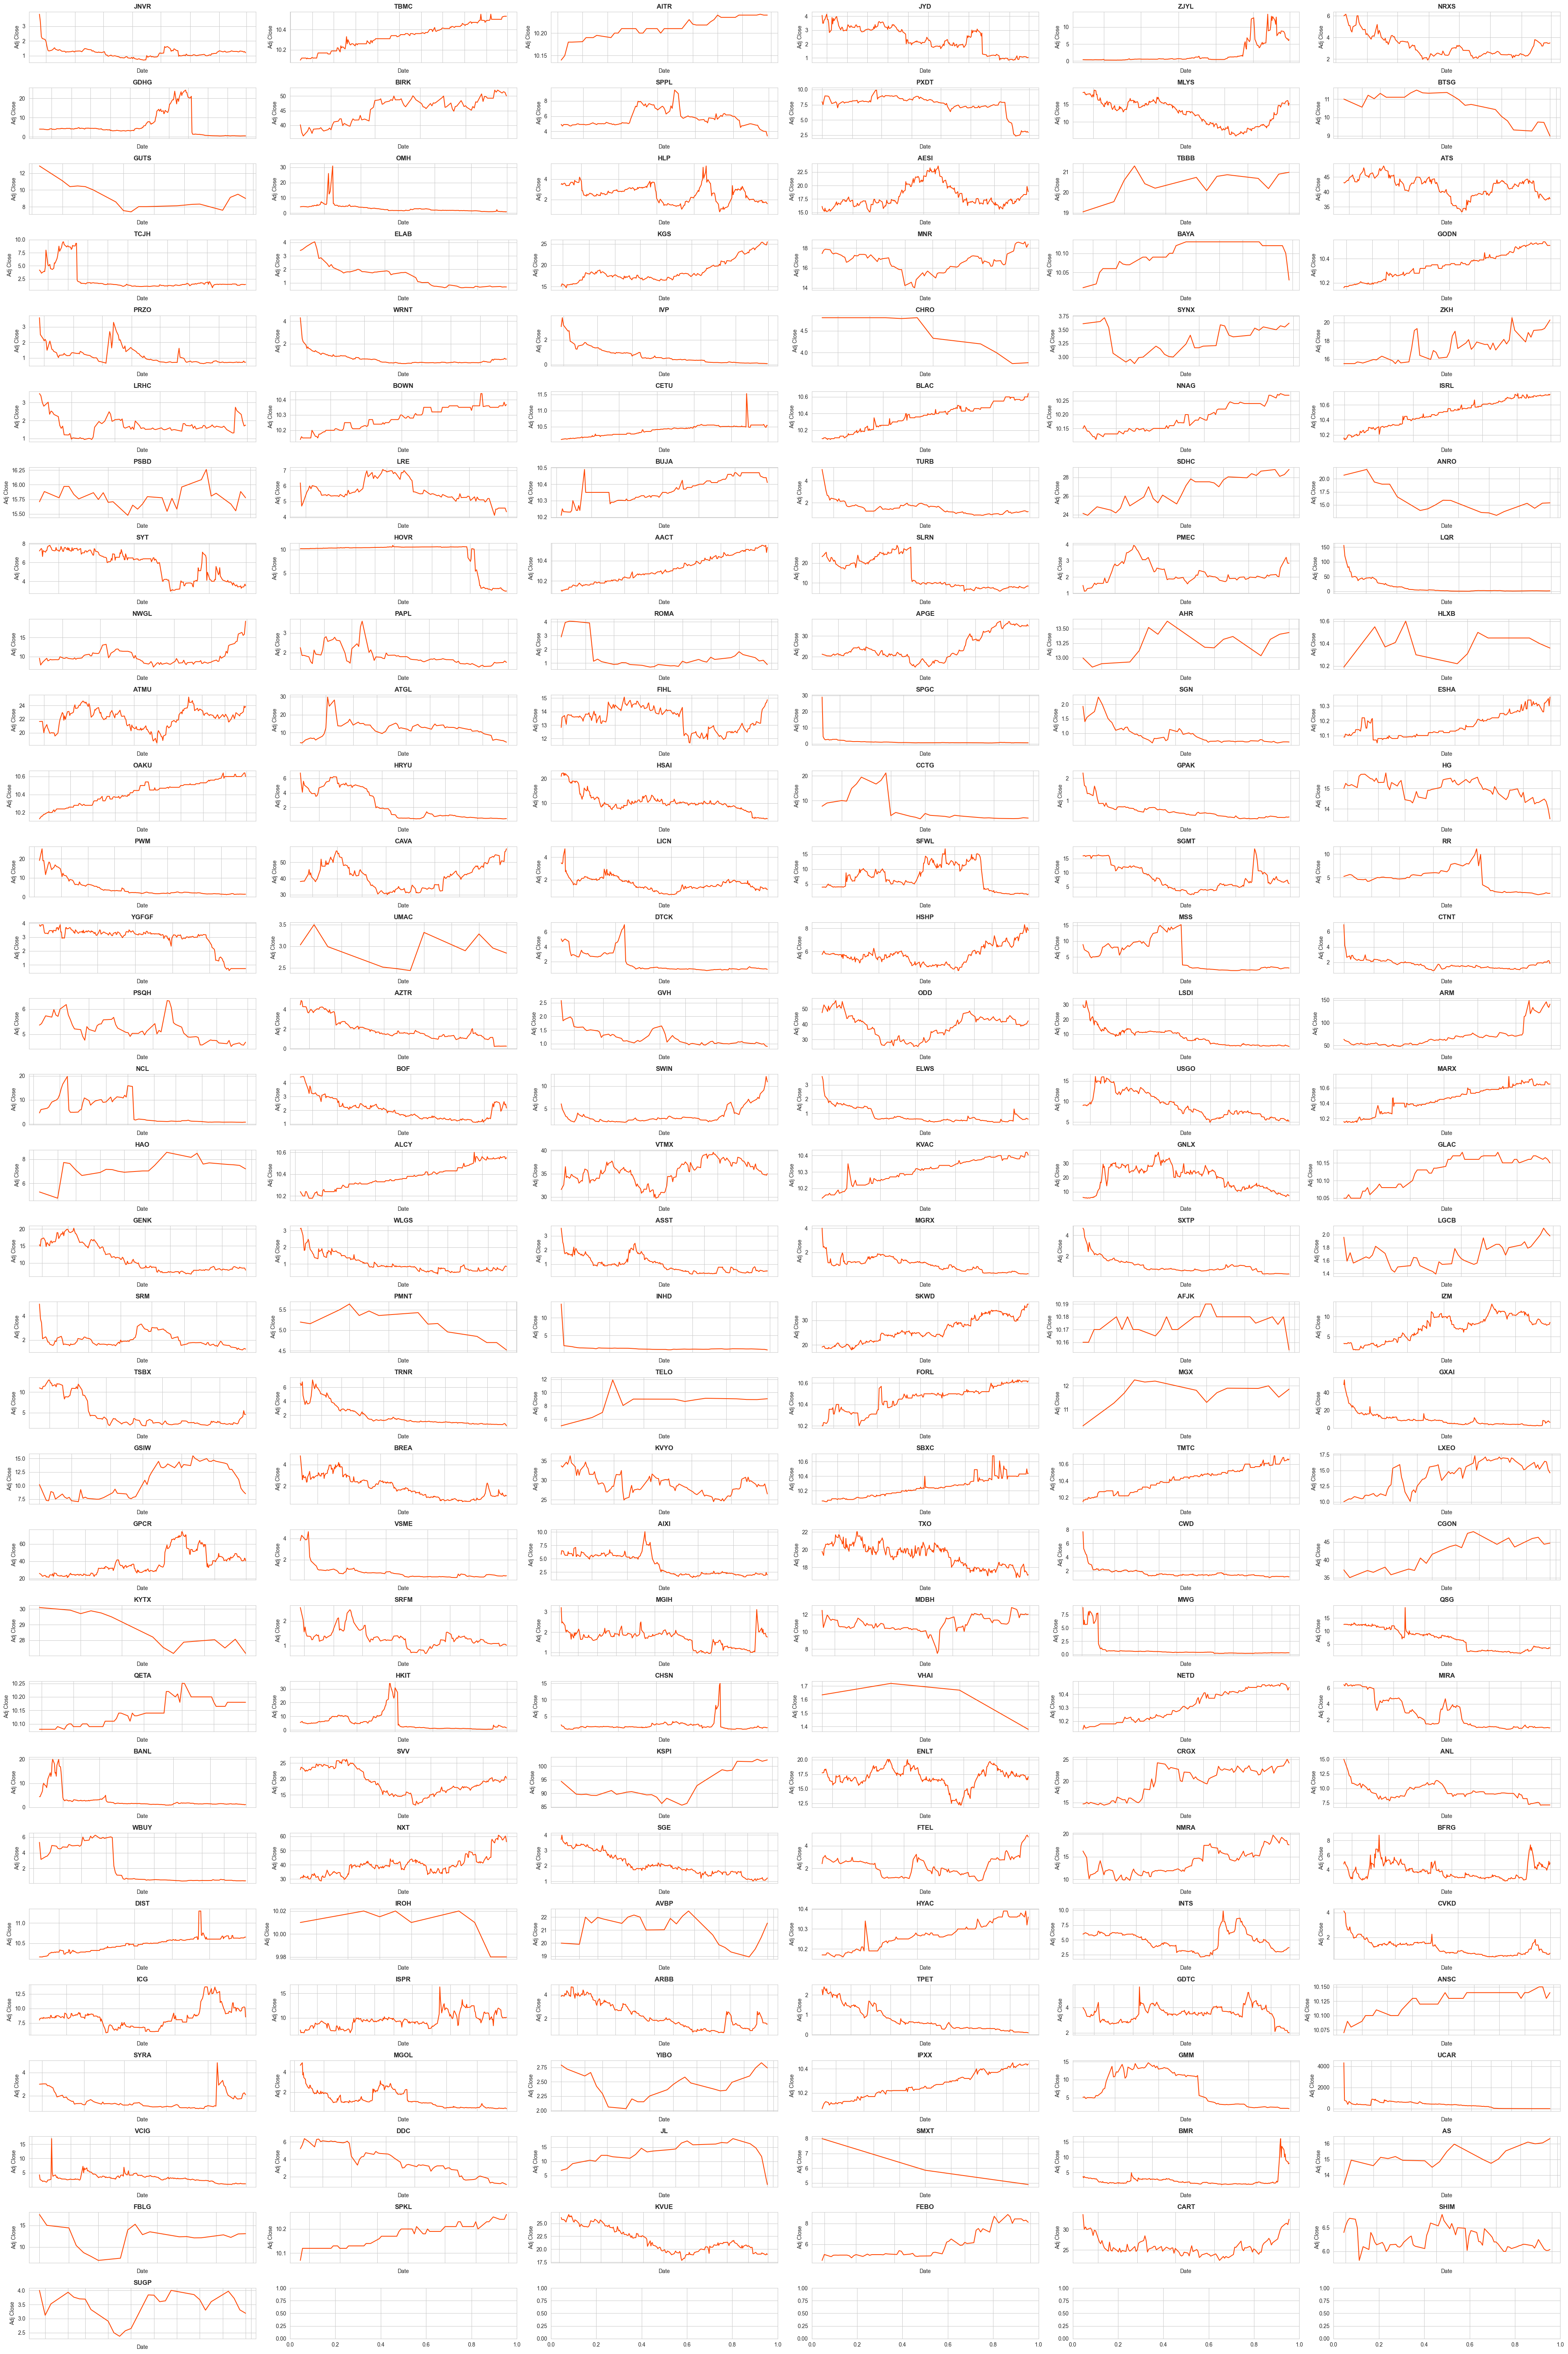

In [167]:
# Assuming `data_frames` is a dictionary containing data for each ticker
tickers   = list(data_frames.keys())
n_tickers = len(tickers)

# Calculate the number of rows and columns needed
n_cols = 6
n_rows = (n_tickers + n_cols - 1) // n_cols  # This ensures there are enough subplots

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(40, 60))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each ticker in its own subplot
for i, ticker in enumerate(tickers):
    sns.lineplot(data=data_frames[ticker], x=data_frames[ticker].index, y='Adj Close', ax=axes[i], color='orangered')
    axes[i].set_title(f'{ticker}', weight='bold')
    # get rid of x tick labels
    axes[i].set_xticklabels([])


plt.tight_layout()

In [184]:
data_frames

{'JNVR':             Adj Close
 Date                 
 2023-07-25      3.820
 2023-07-26      3.290
 2023-07-27      2.300
 2023-07-28      2.170
 2023-07-31      2.100
 ...               ...
 2024-02-23      1.320
 2024-02-26      1.290
 2024-02-27      1.250
 2024-02-28      1.278
 2024-02-29      1.200
 
 [152 rows x 1 columns],
 'TBMC':             Adj Close
 Date                 
 2023-05-15     10.100
 2023-05-16     10.110
 2023-05-17     10.120
 2023-05-18     10.120
 2023-05-19     10.120
 ...               ...
 2024-02-23     10.523
 2024-02-26     10.530
 2024-02-27     10.530
 2024-02-28     10.530
 2024-02-29     10.530
 
 [200 rows x 1 columns],
 'AITR':             Adj Close
 Date                 
 2024-01-02     10.140
 2024-01-03     10.150
 2024-01-04     10.180
 2024-01-05     10.180
 2024-01-08     10.181
 2024-01-09     10.190
 2024-01-10     10.190
 2024-01-11     10.190
 2024-01-12     10.195
 2024-01-16     10.190
 2024-01-17     10.200
 2024-01-18     10.200
 2

In [185]:
data_frames['TBMC']

,Adj Close
Date,
2023-05-15,10.100
2023-05-16,10.110
2023-05-17,10.120
2023-05-18,10.120
2023-05-19,10.120
...,...
2024-02-23,10.523
2024-02-26,10.530
2024-02-27,10.530


- Calculate growth rate for each holding period:

In [196]:
def calculate_growth_rates(df, max_days=31):
    """ Calculate growth rates from first day until every day up until the 30th day.
    Args:
        df (pd.DataFrame): DataFrame containing stock price data.
        max_days (int): Maximum number of days to calculate growth rates for.
    Returns:
        pd.Series: Growth rates from day 0 to each day up to max_days.
    """
    if df.empty or len(df) < 2:
        return pd.Series()  # Return an empty series if there's not enough data

    # Assume 'Adj Close' is the column for adjusted closing prices
    initial_price = df['Adj Close'].iloc[0]
    growth_rates = (df['Adj Close'].iloc[1:max_days+1] / initial_price - 1) * 100
    growth_rates.index = range(1, len(growth_rates) + 1)  # Adjust index to match day count

    return growth_rates

# Apply the function to each DataFrame in your dictionary
ticker_growth_rates = {}
for symbol, df in data_frames.items():
    growth_rates = calculate_growth_rates(df)
    ticker_growth_rates[symbol] = growth_rates

ticker_growth_rates

{'JNVR': 1    -13.874345
 2    -39.790576
 3    -43.193714
 4    -45.026180
 5    -48.691098
 6    -57.329842
 7    -64.136125
 8    -65.445024
 9    -64.136125
 10   -63.089005
 11   -61.518323
 12   -59.685864
 13   -62.303663
 14   -64.397905
 15   -63.089005
 16   -63.612565
 17   -64.921464
 18   -65.968587
 19   -65.968587
 20   -67.801046
 21   -66.753927
 22   -67.015706
 23   -67.015706
 24   -66.492147
 25   -65.706807
 26   -65.968587
 27   -67.277486
 28   -65.837697
 29   -65.445024
 30   -65.445024
 Name: Adj Close, dtype: float64,
 'TBMC': 1     0.099003
 2     0.198015
 3     0.198015
 4     0.198015
 5     0.198015
 6     0.198015
 7     0.118813
 8     0.198015
 9     0.148509
 10    0.148509
 11    0.247521
 12    0.247521
 13    0.198015
 14    0.207920
 15    0.198015
 16    0.198015
 17    0.495042
 18    0.693066
 19    0.693066
 20    0.693066
 21    0.693066
 22    0.693066
 23    0.693066
 24    0.693066
 25    0.693066
 26    0.693066
 27    0.594054
 28    0

- Aggregate growth rates and analyze quantiles:

In [197]:
# Convert the dictionary of growth rates to a DataFrame
growth_df = pd.DataFrame.from_dict(ticker_growth_rates, orient='index')

# Calculate quantiles for each day
quantiles = growth_df.quantile(0.75)  # 75% quantile for each column

In [191]:
growth_df

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
JNVR,-13.874345,-39.790576,-43.193714,-45.026180,-48.691098,-57.329842,-64.136125,-65.445024,-64.136125,-63.089005,...,-66.753927,-67.015706,-67.015706,-66.492147,-65.706807,-65.968587,-67.277486,-65.837697,-65.445024,-65.445024
TBMC,0.099003,0.198015,0.198015,0.198015,0.198015,0.198015,0.118813,0.198015,0.148509,0.148509,...,0.693066,0.693066,0.693066,0.693066,0.693066,0.693066,0.594054,0.594054,0.792078,0.891081
AITR,0.098612,0.394477,0.394477,0.404333,0.493089,0.493089,0.493089,0.542400,0.493089,0.591711,...,0.690332,0.690332,0.690332,0.788954,0.887566,0.788954,0.769231,0.769231,0.838265,0.887566
JYD,-14.004918,-14.054060,-8.353812,-7.862412,1.965600,-7.371012,-7.371012,-14.004918,-30.466835,-26.044229,...,-23.095824,-20.884524,-22.579855,-27.518429,-26.044229,-27.272729,-22.113024,-16.707618,-21.547913,-18.918924
ZJYL,-0.201261,-3.773589,-6.289310,-5.660379,-8.301892,-5.911948,-7.547170,-7.798747,-7.169816,-11.949689,...,-10.062898,-4.025158,20.754712,-26.037737,-30.817610,-29.559750,-28.301889,-29.559750,-28.327043,-29.685534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KVUE,-1.486988,-1.449815,-2.304819,-2.416351,-3.345722,-1.486988,2.230489,0.483279,1.189593,0.520451,...,-6.505574,-6.431215,-6.765804,-6.654264,-6.691444,-6.988839,-6.579919,-5.799246,-4.275086,-2.416351
FEBO,12.837842,8.108111,11.261261,11.486481,11.261261,11.486481,11.486481,10.135131,5.630631,10.360361,...,12.837842,21.171172,19.819822,12.274776,13.738742,15.315311,9.684681,8.558561,9.459461,9.684681
CART,-10.682493,-9.050448,-10.979231,-9.821962,-11.305642,-15.311572,-11.483682,-11.899110,-20.000005,-21.246290,...,-24.599409,-27.507419,-26.261128,-26.943619,-21.661724,-25.341248,-26.735905,-26.083088,-23.353118,-26.913951
SHIM,2.343751,3.906250,4.687495,4.374996,1.562498,-9.218752,-4.687503,-5.625002,0.000000,-1.249999,...,-4.296876,-3.281251,-1.562498,-1.171879,-4.062504,-4.531249,-4.687503,-5.312502,-0.937499,0.781246


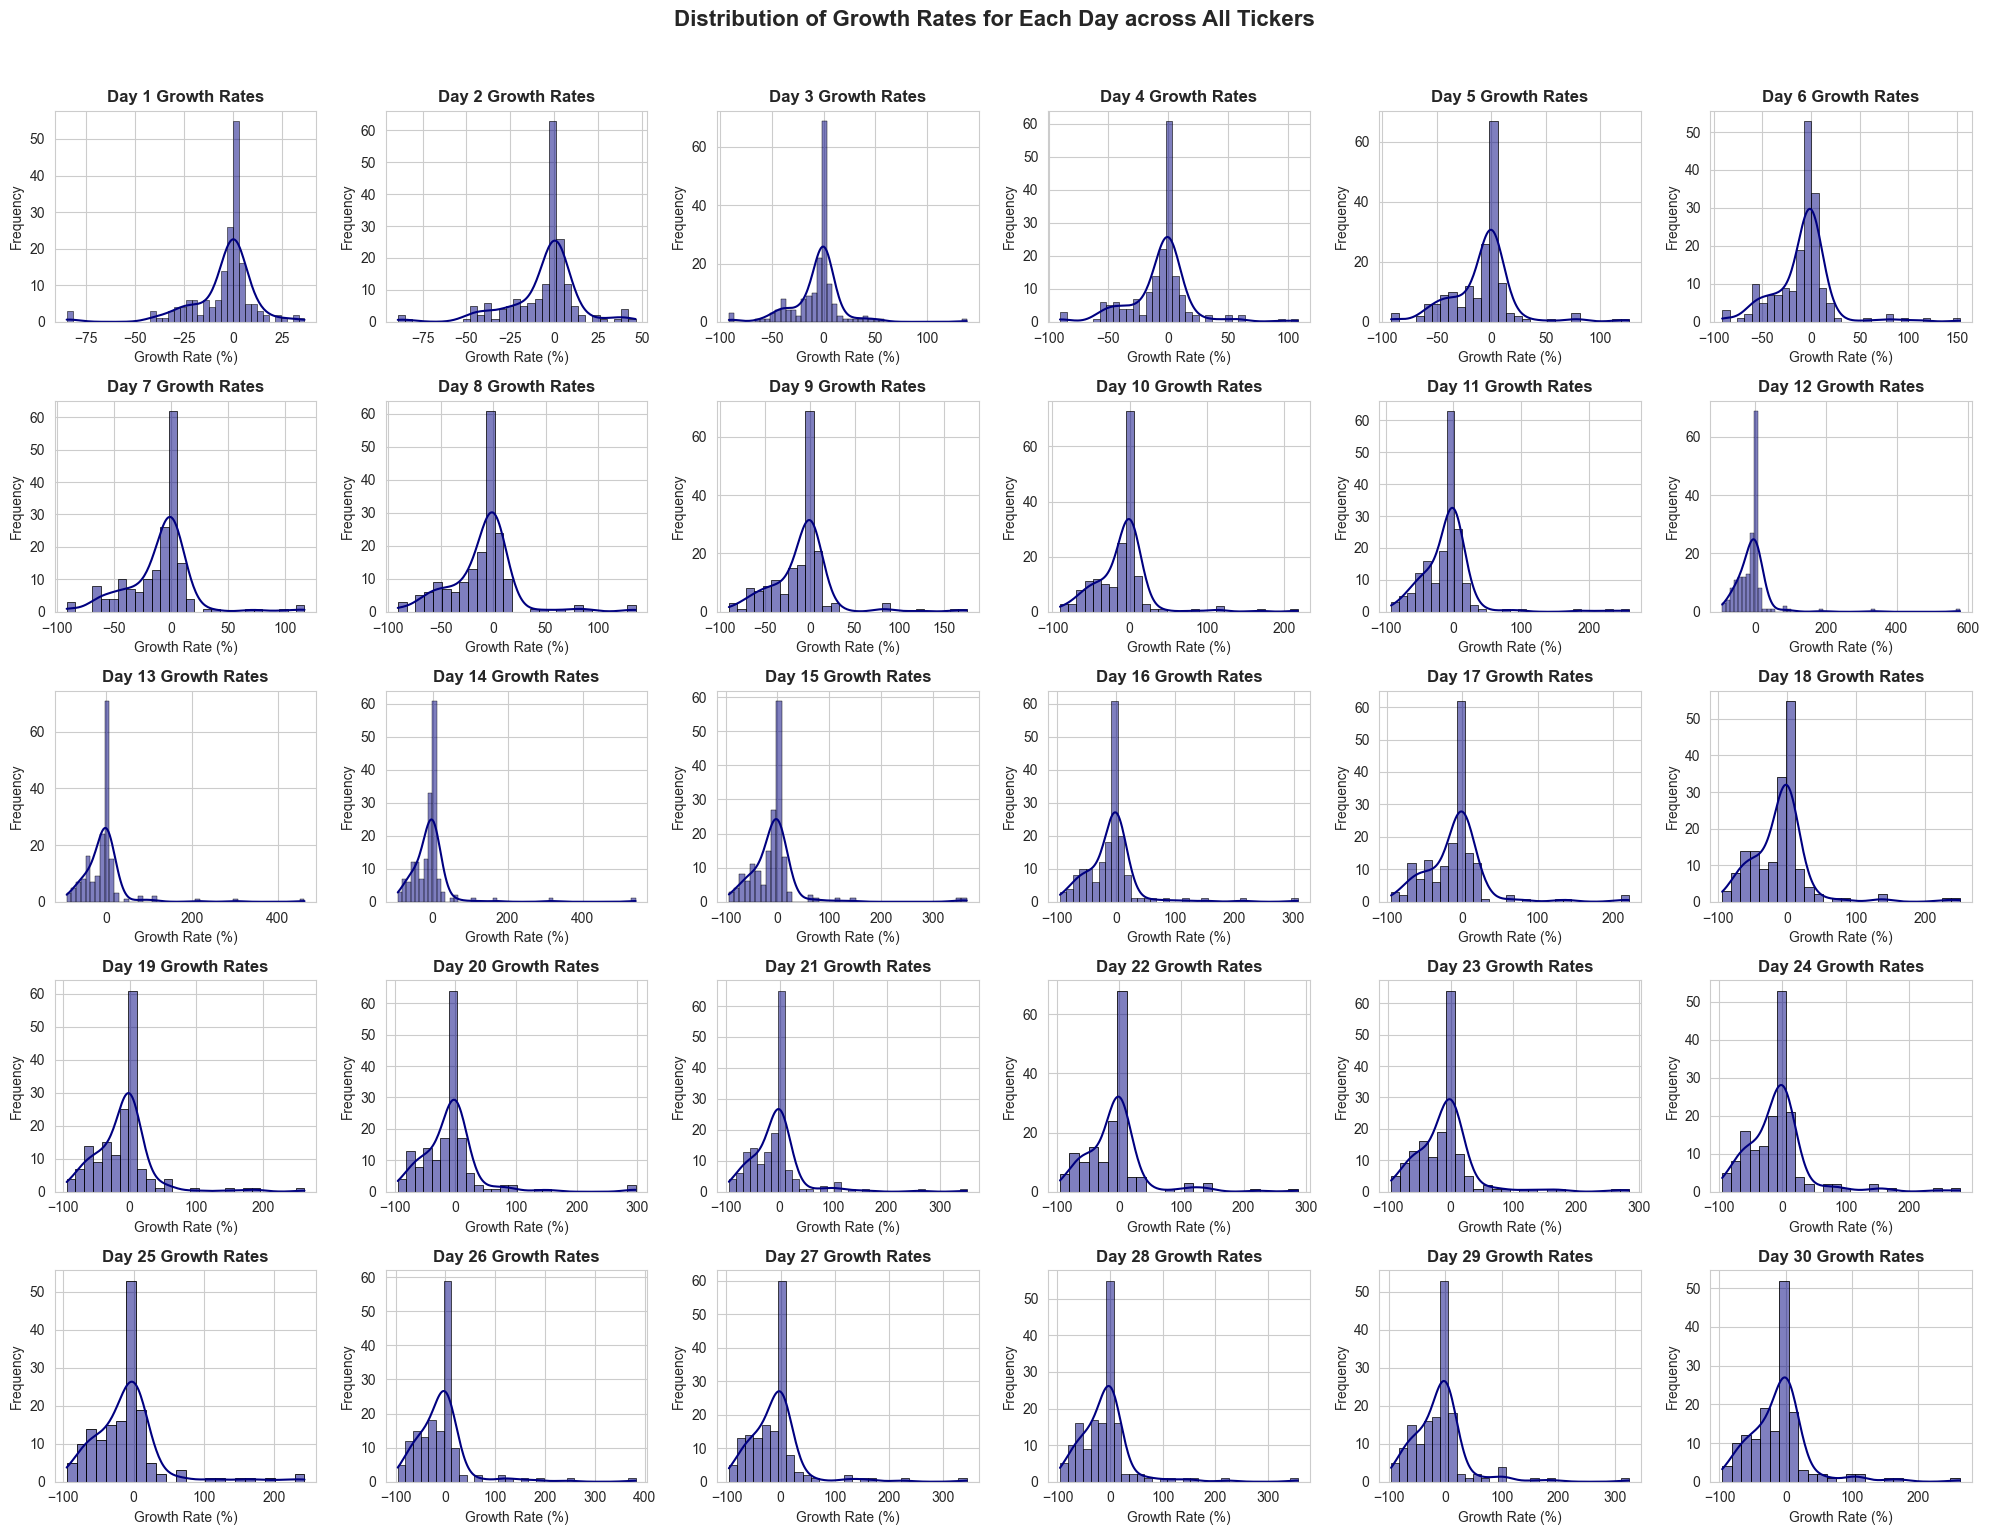

In [192]:
sns.set_style('whitegrid')
# Assume `growth_df` is already defined and contains growth data as described
days = growth_df.columns  # This gets all the column labels which are the days

# Plotting histograms for each day
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
fig.suptitle("Distribution of Growth Rates for Each Day across All Tickers", weight='bold', size=16, y=1.02)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, day in enumerate(days):
    sns.histplot(growth_df[day].dropna(), ax=axes[i], color='navy', edgecolor='black', kde=True, line_kws={'color': 'red'})
    axes[i].set_title(f'Day {day} Growth Rates', weight='bold')
    axes[i].set_xlabel('Growth Rate (%)')
    axes[i].set_ylabel('Frequency')

plt.tight_layout();

In [153]:
quantiles

1     1.805651
2     2.191779
3     1.328919
4     1.633341
5     1.314086
6     0.847389
7     0.720510
8     0.899062
9     1.361572
10    1.632651
11    1.279498
12    1.991289
13    1.940195
14    1.593293
15    1.480978
16    1.371208
17    1.083750
18    1.371208
19    1.816311
20    1.470594
21    1.371208
22    3.233834
23    2.666664
24    2.936603
25    1.755921
26    2.421149
27    2.363760
28    2.727274
29    2.404110
30    2.063006
Name: 0.75, dtype: float64

- Determine optimal X:

In [193]:
optimal_x = quantiles.idxmax()  # Get the day with the highest 75% quantile
print(f"The optimal number of days to hold is: {optimal_x} with a 75% quantile growth of {quantiles[optimal_x]}%")

The optimal number of days to hold is: 22 with a 75% quantile growth of 3.233833707903555%


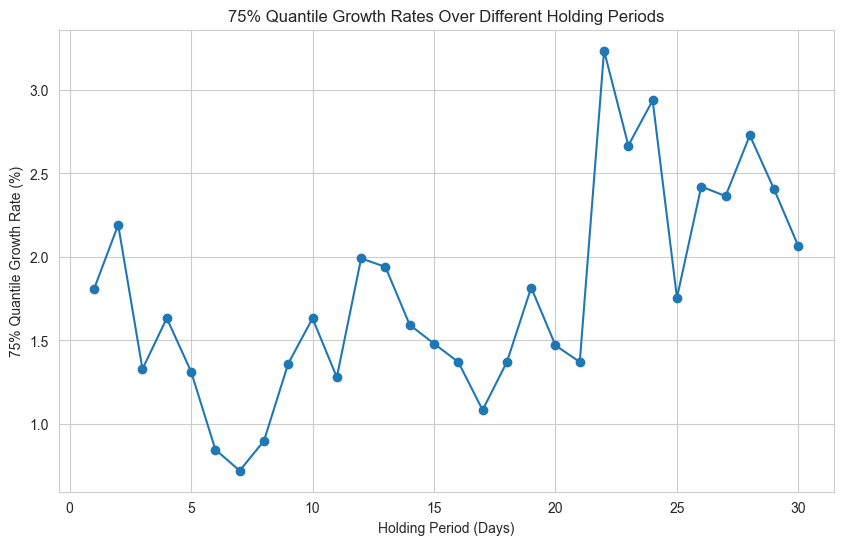

In [155]:
import matplotlib.pyplot as plt

# Example data
days = list(quantiles.keys())
quantile_growth = list(quantiles)

plt.figure(figsize=(10, 6))
plt.plot(days, quantile_growth, marker='o', linestyle='-')
plt.title('75% Quantile Growth Rates Over Different Holding Periods')
plt.xlabel('Holding Period (Days)')
plt.ylabel('75% Quantile Growth Rate (%)')
plt.grid(True)
plt.show()

## ***`Question 3: Is Growth Concentrated in the Largest Stocks?`***
---

Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?

Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks for 10 full years of data (2014-01-01 to 2023-12-31). You'll need to download slightly more data (7 periods before 2014-01-01 to calculate the growth_7d for the first 6 days correctly):

> US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

> EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

> INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

> LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS

Now let's add the top 12-22 stocks (as of end-April 2024):

> NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']

> EW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']

> NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']

> LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS (from the actual stats on Yahoo Finance)

Calculate  growth_7d for every stock and every day. Get the average daily growth_7d for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:
| Date       | ticker_category | growth_7d |
|------------|-----------------|-----------|
| 2014-01-01 | LARGE           | 1.011684  |
| 2014-01-01 | LARGEST         | 1.011797  |

On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.

HINT: you can use `pandas.pivot_table()` to "flatten" the table (LARGE and LARGEST growth_7d as columns)

## ***`Question 4: Trying Another Technical Indicators strategy`***
---

What's the total gross profit (in THOUSANDS of $) you'll get from trading on CCI (no fees assumption)?

First, run the entire Colab to obtain the full DataFrame of data (after [Code Snippet 9]), and truncate it to the last full 10 years of data (2014-01-01 to 2023-12-31). If you encounter any difficulties running the Colab - you can download it using this link: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing.

Let's assume you've learned about the awesome CCI indicator (Commodity Channel Index https://www.investopedia.com/terms/c/commoditychannelindex.asp), and decided to use only it for your operations.

You defined the "defensive" value of a high threshould of 200, and you trade only on Fridays (Date.dt.dayofweek()==4).

That is, every time you see that CCI is >200 for any stock (out of those 33), you'll invest $1000 (each record when CCI>200) at Adj.Close price and hold it for 1 week (5 trading days) in order to sell at the Adj. Close price.

What's the expected gross profit (no fees) that you get in THOUSANDS $ (closest integer value) over many operations in 10 years? One operation calculations: if you invested $1000 and received $1010 in 5 days - you add $10 to gross profit, if you received $980 - add -$20 to gross profit. You need to sum these results over all trades (460 times in 10 years).

Additional:

- Add an approximate fees calculation over the 460 trades from this calculator https://www.degiro.ie/fees/calculator (Product:"Shares, USA and Canada;" Amount per transaction: "1000 EUR"; Transactions per year: "460")
- are you still profitable on those trades?


## ***`[EXPLORATORY] Question 5: Finding Your Strategy for IPOs`***
---

You've seen in the first questions that the median and average investments are negative in IPOs, and you can't blindly invest in all deals.

How would you correct/refine the approach? Briefly describe the steps and the data you'll try to get (it should be generally feasible to do it from public sources - no access to internal data of companies)?

E.g. (some ideas) Do you want to focus on the specific vertical? Do you want to build a smart comparison vs. existing stocks on the market? Or you just will want to get some features (which features?) like total number of people in a company to find a segment of "successful" IPOs?